# Import Libraries and Data

In [1]:
# import relevant modeling + other libraries
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pickle as pkl
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB, CategoricalNB, ComplementNB
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
import xgboost as xgb
import statsmodels.api as sm
import warnings
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [2]:
# open data
with open('data/full_data.pkl','rb') as f:
    df = pkl.load(f)

# Select the features and target for our modeling

In [3]:
# these are the features that will be used to build our model.
# most are nominal/dummied data (ie which borough or direction a delay occured in)
# other are interval (ie temperature and wind speed)
features = ['bronx','brooklyn', 'manhattan', 'queens', 'direction_bronx', 'direction_brooklyn', 'direction_manhattan',
            'direction_queens', 'direction_both', 'direction_north', 'direction_south',
            'mon', 'tue', 'wed', 'th', 'fri', 'weekend','holiday','rush_hour', 
            'max_temp', 'avg_temp', 'min_temp', 'avg_wind_spd', 'fastest_wind_spd','major_conditions',
             'minor_conditions', 'neutral_conditions', 'clear_conditions', 'prcp', 'snowfall', 'snowfall_depth',]

In [4]:
# creating the target column
df.insert(0,'delayed_all',0)
ind_both = df.loc[(df['delayed_div_a']==1)&(df['delayed_div_b']==1)].index
ind_a = df.loc[(df['delayed_div_a']==1)&~((df['delayed_div_a']==1)&(df['delayed_div_b']==1))].index
ind_b = df.loc[(df['delayed_div_b']==1)&~((df['delayed_div_a']==1)&(df['delayed_div_b']==1))].index
df.loc[ind_a,'delayed_all'] = 0
df.loc[ind_b,'delayed_all'] = 1
df.loc[ind_both,'delayed_all'] = 2
df['delayed_all'].value_counts()

1    47389
0    32213
2      105
Name: delayed_all, dtype: int64

In [5]:
# initiate a list that we'll add the model names and scores to
models_and_scores = {}

# LogReg

In [6]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Pipeline(steps=[('lr',
                 LogisticRegression(C=0.2, penalty='none', solver='saga'))])


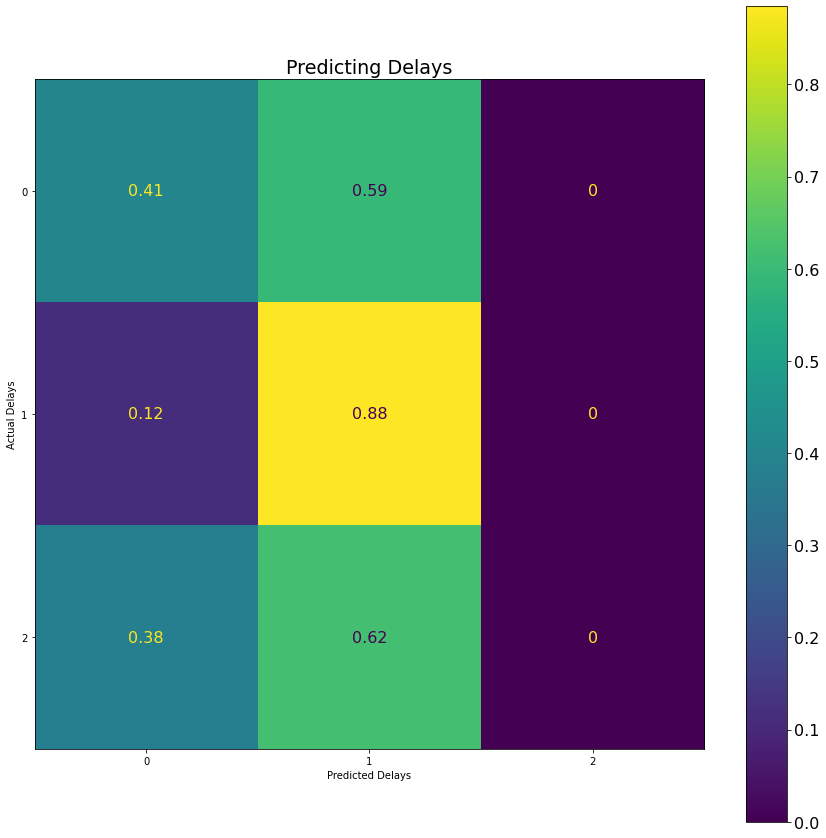


Overall Accuracy: LogReg Acc: 69.07%%,
F1 Score: LogReg F1: 69.07%%



In [7]:
# I ran this before, took a lot of RAM, best solver was saga...
lr = LogisticRegression()
lr_params = {'lr__C':[.2,.5,.7,.9,1],
            'lr__solver':['saga'],
            'lr__penalty':['l2','none']}
pipe_lr = Pipeline(steps=[('lr',LogisticRegression())])

gsv_lr = GridSearchCV(pipe_lr,lr_params,scoring='homogeneity_score')

gsv_lr.fit(X_train,y_train)

y_pred = gsv_lr.best_estimator_.predict(X_test)

print(gsv_lr.best_estimator_)

fig, ax = plt.subplots(figsize=(15,15))
plt.rcParams.update({'font.size':16})
plot_confusion_matrix(gsv_lr,X_test,y_test,normalize='true',ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()

acc_lr = f"LogReg Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_lr = f"LogReg F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_lr}%,
F1 Score: {f1_lr}%
""")

models_and_scores.update({"LogReg":[acc_lr,f1_lr]})

# Clustering

## KNN Classification

In [8]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Pipeline(steps=[('knn',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3,
                                      weights='distance'))])


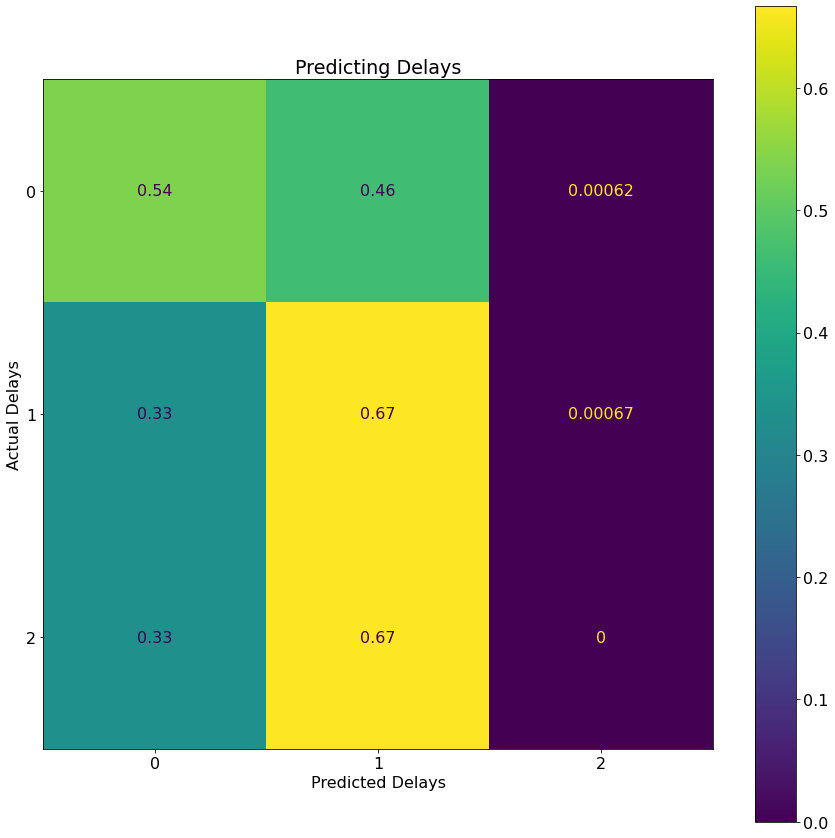


Overall Accuracy: KNN Acc: 61.309999999999995%%,
F1 Score: KNN F1: 61.309999999999995%%



In [9]:
knn_params = {'knn__n_neighbors':[3,5,7],
             'knn__weights':['uniform','distance'],
             'knn__algorithm':['auto','ball_tree','kd_tree','brute'],
             'knn__metric':['minkowski','euclidean','manhattan']}
pipe_knn = Pipeline(steps=[('knn',KNeighborsClassifier())])

gsv_knn = GridSearchCV(pipe_knn,knn_params,scoring='homogeneity_score')

gsv_knn.fit(X_train,y_train)

y_pred = gsv_knn.best_estimator_.predict(X_test)

print(gsv_knn.best_estimator_)

fig, ax = plt.subplots(figsize=(15,15))
plt.rcParams.update({'font.size':16})
plot_confusion_matrix(gsv_knn,X_test,y_test,normalize='true',ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()

acc_knn = f"KNN Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_knn = f"KNN F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_knn}%,
F1 Score: {f1_knn}%
""")

models_and_scores.update({"KNN":[acc_knn,f1_knn]})

## KMeans Clustering

In [10]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
kmeans_params = {'km__n_clusters':[3],
                 'km__algorithm':['auto','full','elkan']}
pipe_km = Pipeline(steps=[('km',KMeans())])

gsv_km = GridSearchCV(pipe_km,kmeans_params,scoring='homogeneity_score')

gsv_km.fit(X_train, y_train)

y_pred = gsv_km.best_estimator_.predict(X_test)

print(gsv_km.best_estimator_)

acc_km = f"KMeans Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_km = f"KMeans F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_km}%,
F1 Score: {f1_km}%
""")

models_and_scores.update({"KMeans":[acc_km,f1_km]})

Pipeline(steps=[('km', KMeans(algorithm='elkan', n_clusters=3))])

Overall Accuracy: KMeans Acc: 32.86%%,
F1 Score: KMeans F1: 32.86%%



# Naive Bayes

## Gaussian NB

In [12]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

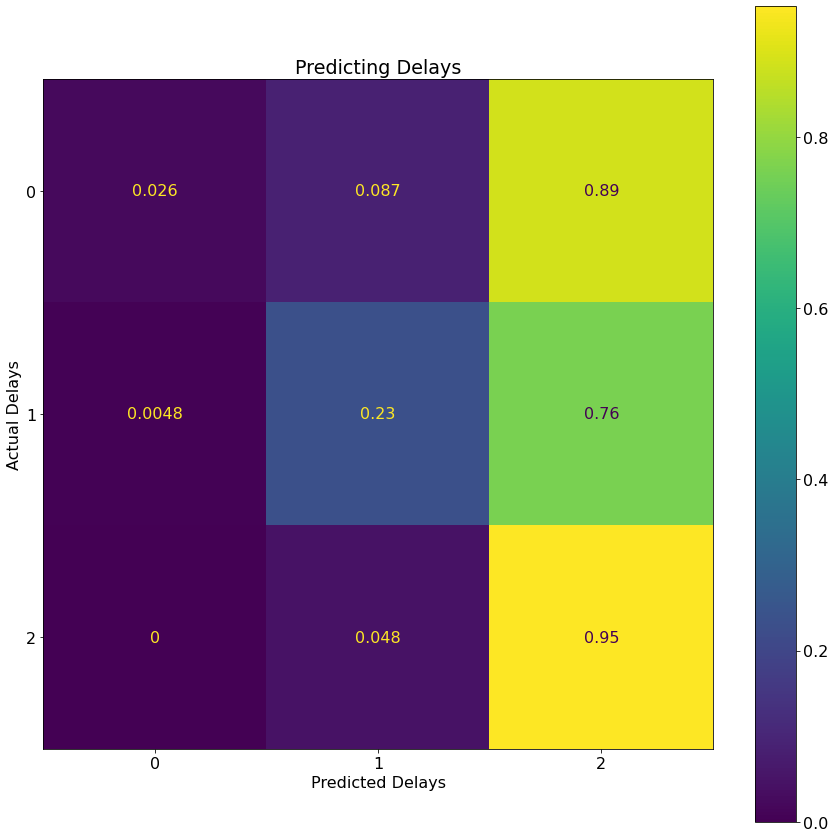


Overall Accuracy: GNB Acc: 14.99%%,
F1 Score: GNB F1: 14.99%%



In [13]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

fig, ax = plt.subplots(figsize=(15,15))
plt.rcParams.update({'font.size':16})
plot_confusion_matrix(gnb,X_test,y_test,normalize='true',ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()

acc_gnb = f"GNB Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_gnb = f"GNB F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_gnb}%,
F1 Score: {f1_gnb}%
""")

models_and_scores.update({"GNB":[acc_gnb,f1_gnb]})

## Complement NB

In [14]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Pipeline(steps=[('cnb', ComplementNB(alpha=1, norm='True'))])


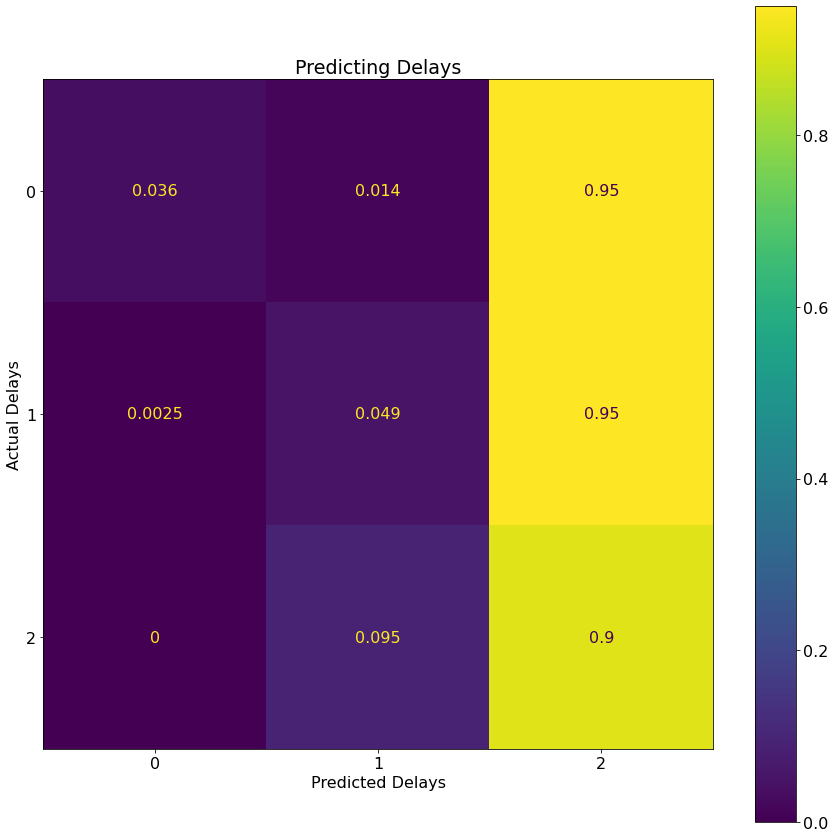


Overall Accuracy: CNB Acc: 4.45%%,
F1 Score: CNB F1: 4.45%%



In [15]:
cnb_params = {'cnb__alpha':[1,.9,.5,.2,0],
             'cnb__norm':['True','False']}
pipe_cnb = Pipeline(steps=[('cnb',ComplementNB())])

gsv_cnb = GridSearchCV(pipe_cnb,cnb_params,scoring='homogeneity_score')

gsv_cnb.fit(X_train,y_train)

y_pred = gsv_cnb.best_estimator_.predict(X_test)

print(gsv_cnb.best_estimator_)

y_pred = gsv_cnb.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_cnb, X_test, y_test, normalize='true', ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()

acc_cnb = f"CNB Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_cnb = f"CNB F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_cnb}%,
F1 Score: {f1_cnb}%
""")

models_and_scores.update({"CNB":[acc_cnb,f1_cnb]})

## Multinomial NB

In [16]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Pipeline(steps=[('mnb', MultinomialNB(alpha=0.2, fit_prior='True'))])


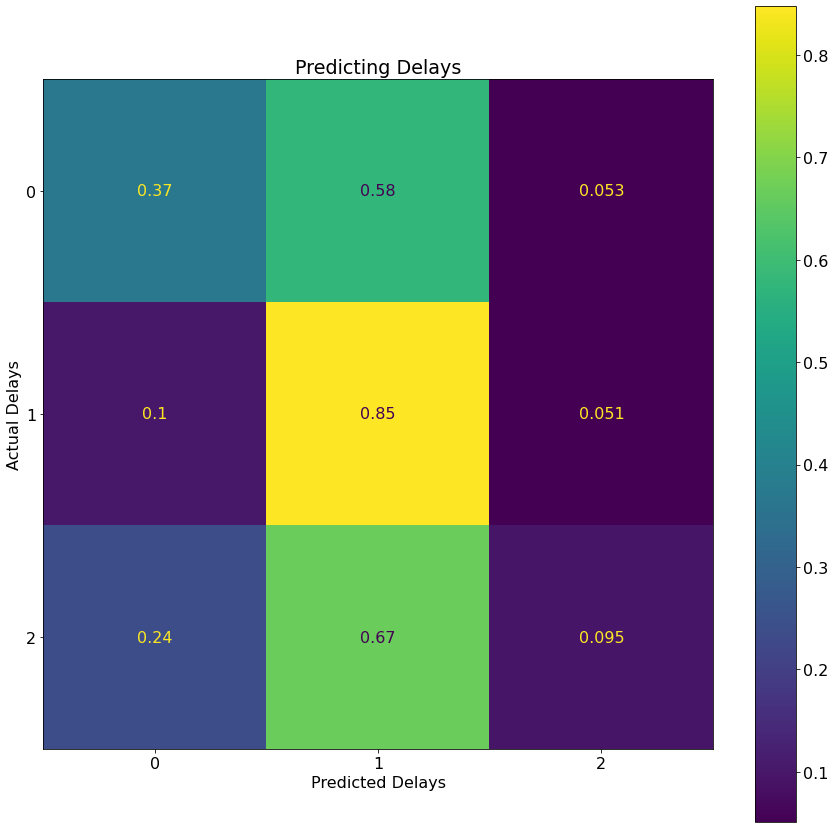


Overall Accuracy: MNB Acc: 65.38000000000001%%,
F1 Score: MNB F1: 65.38000000000001%%



In [17]:
mnb_params = {'mnb__alpha':[1,.9,.5,.2,0],
             'mnb__fit_prior':['True','False']}
pipe_mnb = Pipeline(steps=[('mnb',MultinomialNB())])

gsv_mnb = GridSearchCV(pipe_mnb,mnb_params,scoring='homogeneity_score')

gsv_mnb.fit(X_train,y_train)

y_pred = gsv_mnb.best_estimator_.predict(X_test)

print(gsv_mnb.best_estimator_)

y_pred = gsv_mnb.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_mnb, X_test, y_test, normalize='true', ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()

acc_mnb = f"MNB Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_mnb = f"MNB F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_mnb}%,
F1 Score: {f1_mnb}%
""")

models_and_scores.update({"MNB":[acc_mnb,f1_mnb]})

## Bernoulli NB

In [53]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

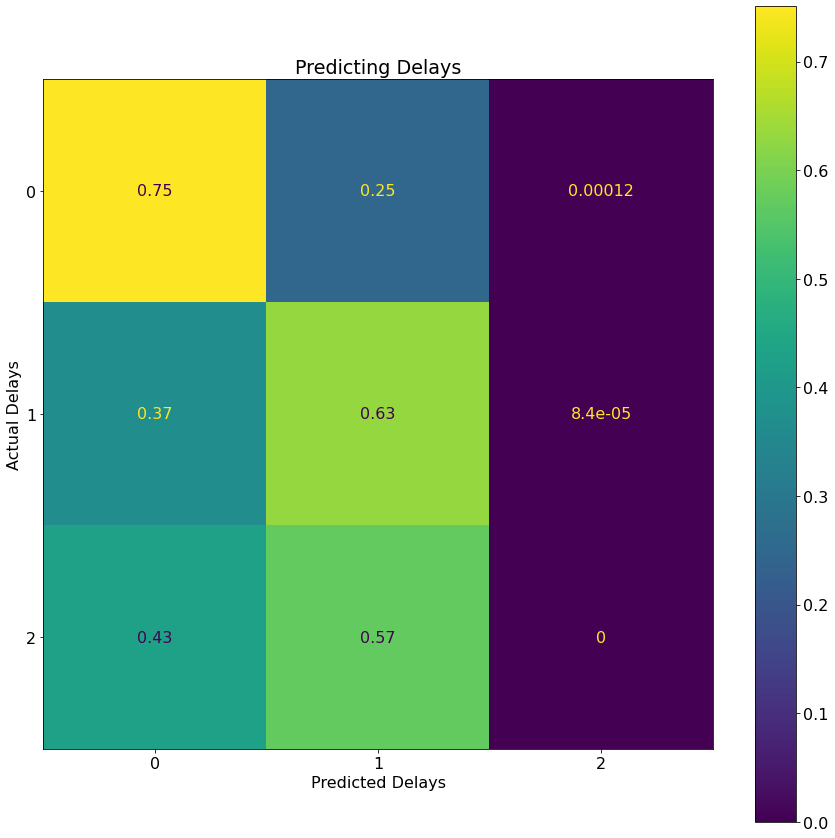

Pipeline(steps=[('bnb', BernoulliNB(alpha=0.9))])

Overall Accuracy: BNB Acc: 67.88%%,
F1 Score: BNB F1: 67.88%%



In [54]:
bnb_params = {'bnb__alpha':[1,.9,.5,.2,0]}
pipe_bnb = Pipeline(steps=[('bnb',BernoulliNB())])

gsv_bnb = GridSearchCV(pipe_bnb, bnb_params,scoring='homogeneity_score')

gsv_bnb.fit(X_train, y_train)
y_pred = gsv_bnb.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_bnb, X_test, y_test, normalize='true', ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()


print(gsv_bnb.best_estimator_)

acc_bnb = f"BNB Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_bnb = f"BNB F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_bnb}%,
F1 Score: {f1_bnb}%
""")

models_and_scores.update({"BNB":[acc_bnb,f1_bnb]})

## Categorical NB

In [20]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

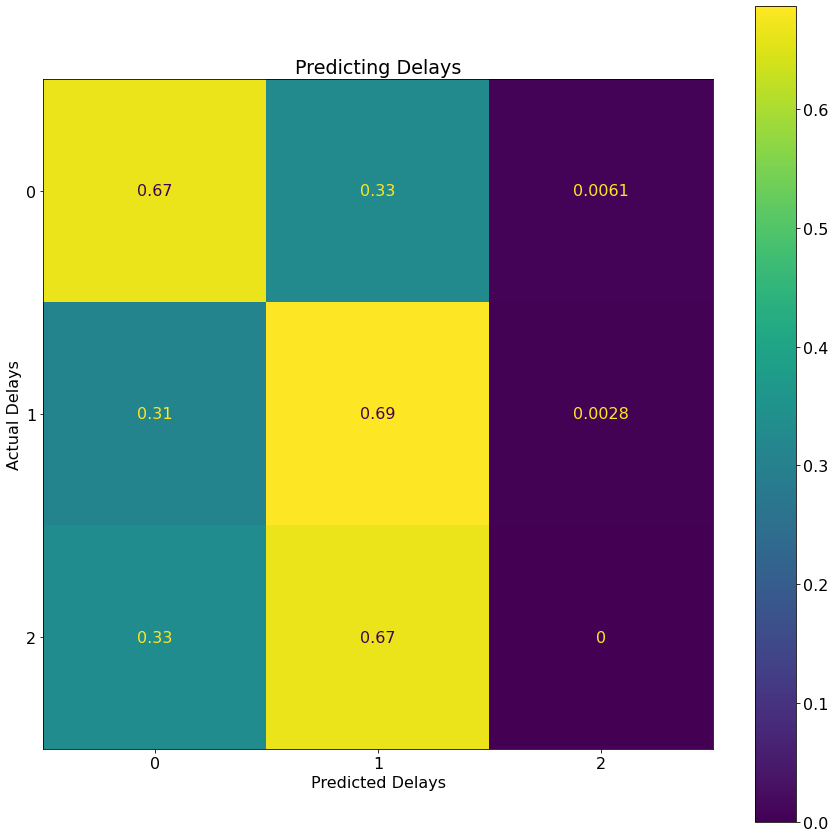

Pipeline(steps=[('canb', CategoricalNB(alpha=0.2, fit_prior='True'))])

Overall Accuracy: CaNB Acc: 67.75%%,
F1 Score: CaNB F1: 67.75%%



In [21]:
canb_params = {'canb__alpha':[1,.9,.5,.2,0],
              'canb__fit_prior':['True','False']
              }
pipe_canb = Pipeline(steps=[('canb',CategoricalNB())])

gsv_canb = GridSearchCV(pipe_canb, canb_params,scoring='homogeneity_score')

gsv_canb.fit(X_train, y_train)
y_pred = gsv_canb.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_canb, X_test, y_test, normalize='true', ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()


print(gsv_canb.best_estimator_)

acc_canb = f"CaNB Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_canb = f"CaNB F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_canb}%,
F1 Score: {f1_canb}%
""")

models_and_scores.update({"CANB":[acc_canb,f1_canb]})

# XGBoost

In [22]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [23]:
xg_cl = xgb.XGBClassifier()
xg_cl.fit(X_train,y_train)
train_score = f"XGB Train Score: {round(xg_cl.score(X_train, y_train),4)}"
test_score = f"XGB Test Score: {round(xg_cl.score(X_test,y_test),4)}"

print(train_score, '\\', test_score)

models_and_scores.update({"XGB":[train_score,test_score]})

[19:02:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Train Score: 0.7427 \ XGB Test Score: 0.6916


# Classification/Decision Tree

## Decision Tree

In [24]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

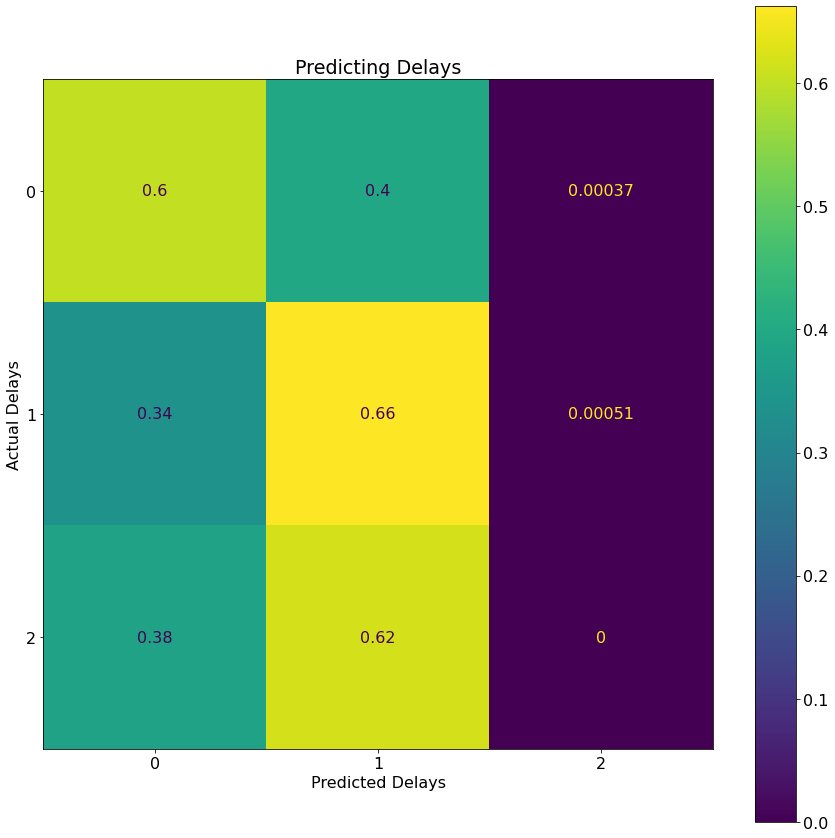

Pipeline(steps=[('clf',
                 DecisionTreeClassifier(criterion='entropy',
                                        max_features='auto'))])

Overall Accuracy: DT Acc: 63.739999999999995%%,
F1 Score: DT F1: 63.739999999999995%%



In [25]:
clf_params = {'clf__criterion':['gini','entropy'],
              'clf__max_features':['auto','sqrt','log2']
              }
pipe_clf = Pipeline(steps=[('clf',DecisionTreeClassifier())])

gsv_clf = GridSearchCV(pipe_clf, clf_params,scoring='homogeneity_score')

gsv_clf.fit(X_train, y_train)
y_pred = gsv_clf.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_clf, X_test, y_test, normalize='true', ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()


print(gsv_clf.best_estimator_)

acc_dt = f"DT Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_dt = f"DT F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_dt}%,
F1 Score: {f1_dt}%
""")

models_and_scores.update({"DT":[acc_dt,f1_dt]})

## Random Forest

In [26]:
X = df[features]
y = df['delayed_all']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

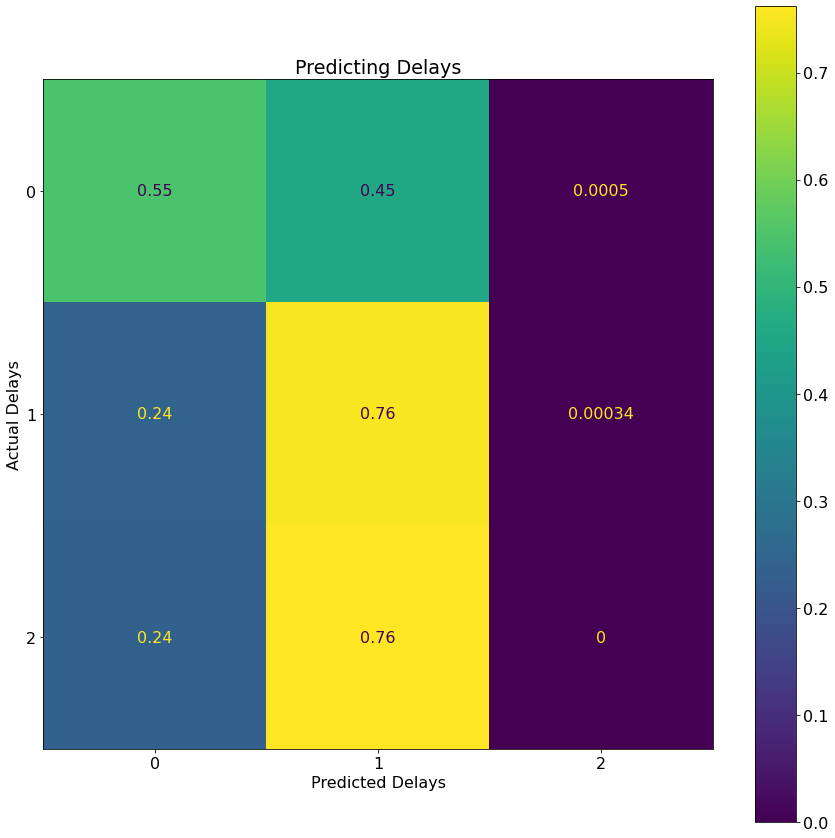

Pipeline(steps=[('clf', RandomForestClassifier(criterion='entropy'))])

Overall Accuracy: RF Acc: 67.05%%,
F1 Score: RF F1: 67.05%%



In [27]:
clf_params = {'clf__criterion':['gini','entropy'],
              'clf__max_features':['auto','sqrt','log2']
              }
pipe_clf = Pipeline(steps=[('clf',RandomForestClassifier())])

gsv_clf = GridSearchCV(pipe_clf, clf_params,scoring='homogeneity_score')

gsv_clf.fit(X_train, y_train)
y_pred = gsv_clf.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_clf, X_test, y_test, normalize='true', ax=ax)
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting Delays')
plt.show()


print(gsv_clf.best_estimator_)

acc_rf = f"RF Acc: {(round(accuracy_score(y_test, y_pred), 4)*100)}%"
f1_rf = f"RF F1: {(round(f1_score(y_test,y_pred,average='micro'),4)*100)}%"

print(f"""
Overall Accuracy: {acc_rf}%,
F1 Score: {f1_rf}%
""")

models_and_scores.update({"RF":[acc_rf,f1_rf]})

In [28]:
models_and_scores

{'LogReg': ['LogReg Acc: 69.07%', 'LogReg F1: 69.07%'],
 'KNN': ['KNN Acc: 61.309999999999995%', 'KNN F1: 61.309999999999995%'],
 'KMeans': ['KMeans Acc: 32.86%', 'KMeans F1: 32.86%'],
 'GNB': ['GNB Acc: 14.99%', 'GNB F1: 14.99%'],
 'CNB': ['CNB Acc: 4.45%', 'CNB F1: 4.45%'],
 'MNB': ['MNB Acc: 65.38000000000001%', 'MNB F1: 65.38000000000001%'],
 'BNB': ['BNB Acc: 67.88%', 'BNB F1: 67.88%'],
 'CANB': ['CaNB Acc: 67.75%', 'CaNB F1: 67.75%'],
 'XGB': ['XGB Train Score: 0.7427', 'XGB Test Score: 0.6916'],
 'DT': ['DT Acc: 63.739999999999995%', 'DT F1: 63.739999999999995%'],
 'RF': ['RF Acc: 67.05%', 'RF F1: 67.05%']}

In [45]:
"""
Top Models:

XGBoost - 69.16% Validation Score

Log Reg - 69.07% Accuracy and Validation

BNB - 67.88% Accuracy and Validation
"""

model_xgb = xg_cl
model_lr = gsv_lr.best_estimator_
model_bnb = gsv_bnb.best_estimator_

# Individual Lines

## Div A Trains

### BNB

In [55]:
X = df[features]
y = df['delayed_div_a']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

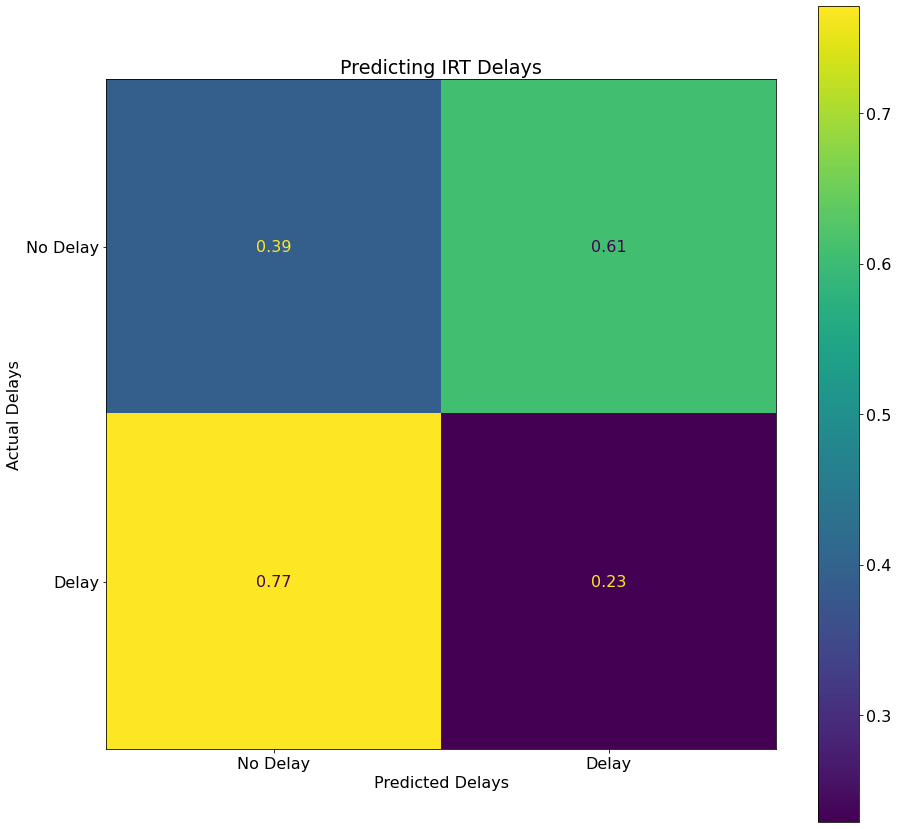


Overall Accuracy: 32.07%,

Overall SMOTE Accuracy: 32.7%,
SMOTE F1 Score: 21.59%


In [66]:
y_pred = gsv_bnb.best_estimator_.predict(X_test)
y_pred_sm = gsv_bnb_sm.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_bnb_sm, X_test, y_test, normalize='true', ax=ax, display_labels=['No Delay','Delay'])
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting IRT Delays')
plt.show()

print(f"""
Overall Accuracy: {(round(accuracy_score(y_test, y_pred), 4)*100)}%,

Overall SMOTE Accuracy: {(round(accuracy_score(y_test, y_pred_sm), 4)*100)}%,
SMOTE F1 Score: {(round(f1_score(y_test,y_pred_sm),4)*100)}%""")

### LogReg

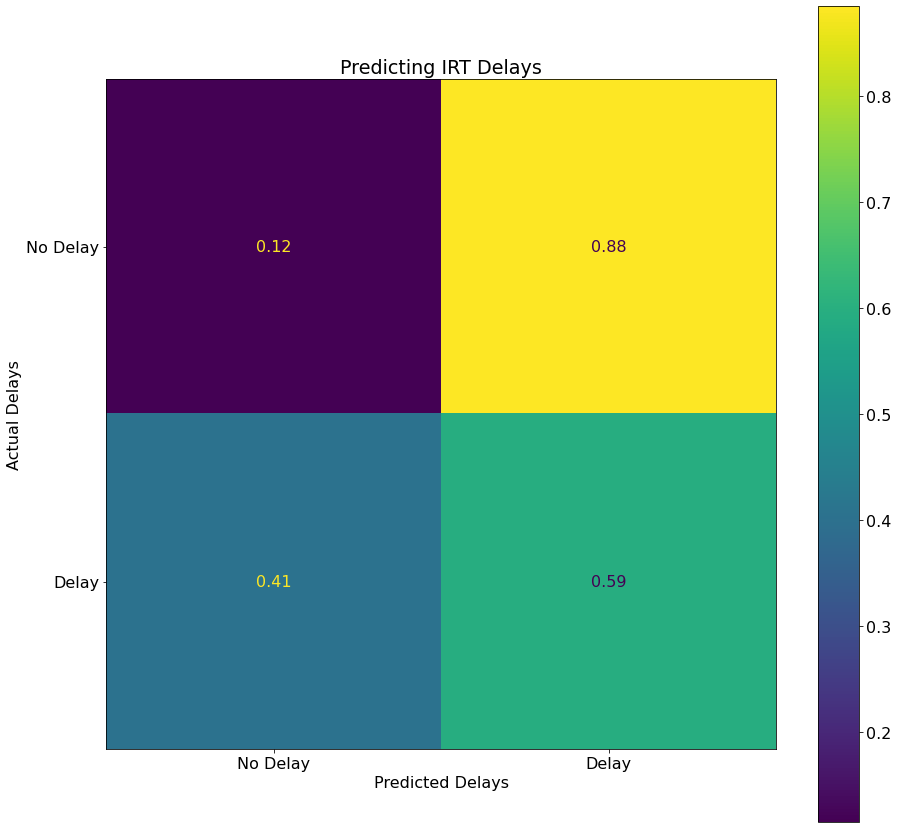


Overall Accuracy: 30.89%,
F1 Score: 41.0%


In [69]:
y_pred = gsv_lr.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_lr, X_test, y_test, normalize='true', ax=ax, display_labels=['No Delay','Delay'])
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting IRT Delays')
plt.show()

print(f"""
Overall Accuracy: {(round(accuracy_score(y_test, y_pred), 4)*100)}%,
F1 Score: {(round(f1_score(y_test,y_pred),4)*100)}%""")

### XGBoost

In [73]:
y_pred = xg_cl.predict(X_test)

# fig, ax = plt.subplots(figsize=(15, 15))
# plt.rcParams.update({'font.size': 16})
# plot_confusion_matrix(xg_cl, X_test, y_test, normalize='true', ax=ax, display_labels=['No Delay','Delay'])
# ax.set_xlabel('Predicted Delays')
# ax.set_ylabel('Actual Delays')
# ax.set_title('Predicting IRT Delays')
# plt.show()

print(f"""
Overall Accuracy: {(round(accuracy_score(y_test, y_pred), 4)*100)}%""")


Overall Accuracy: 30.769999999999996%


## Div B Trains

In [74]:
X = df[features]
y = df['delayed_div_b']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

### BNB

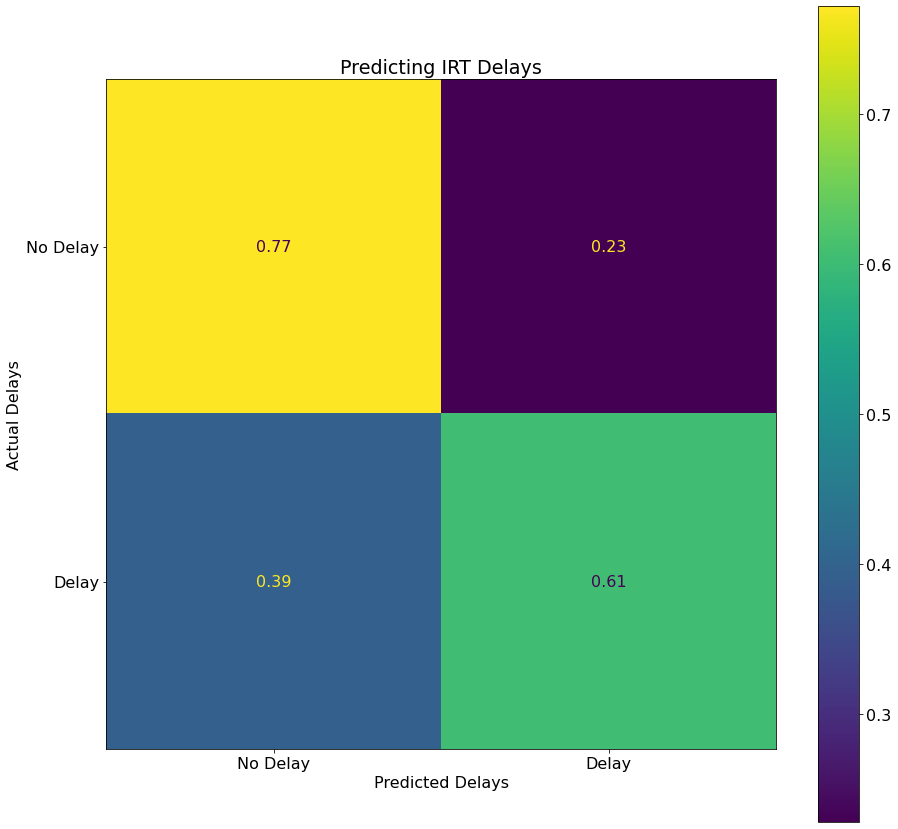


Overall Accuracy: 67.94%,

Overall SMOTE Accuracy: 67.29%,
SMOTE F1 Score: 68.85%


In [75]:
y_pred = gsv_bnb.best_estimator_.predict(X_test)
y_pred_sm = gsv_bnb_sm.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_bnb_sm, X_test, y_test, normalize='true', ax=ax, display_labels=['No Delay','Delay'])
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting IRT Delays')
plt.show()

print(f"""
Overall Accuracy: {(round(accuracy_score(y_test, y_pred), 4)*100)}%,

Overall SMOTE Accuracy: {(round(accuracy_score(y_test, y_pred_sm), 4)*100)}%,
SMOTE F1 Score: {(round(f1_score(y_test,y_pred_sm),4)*100)}%""")

### LogReg

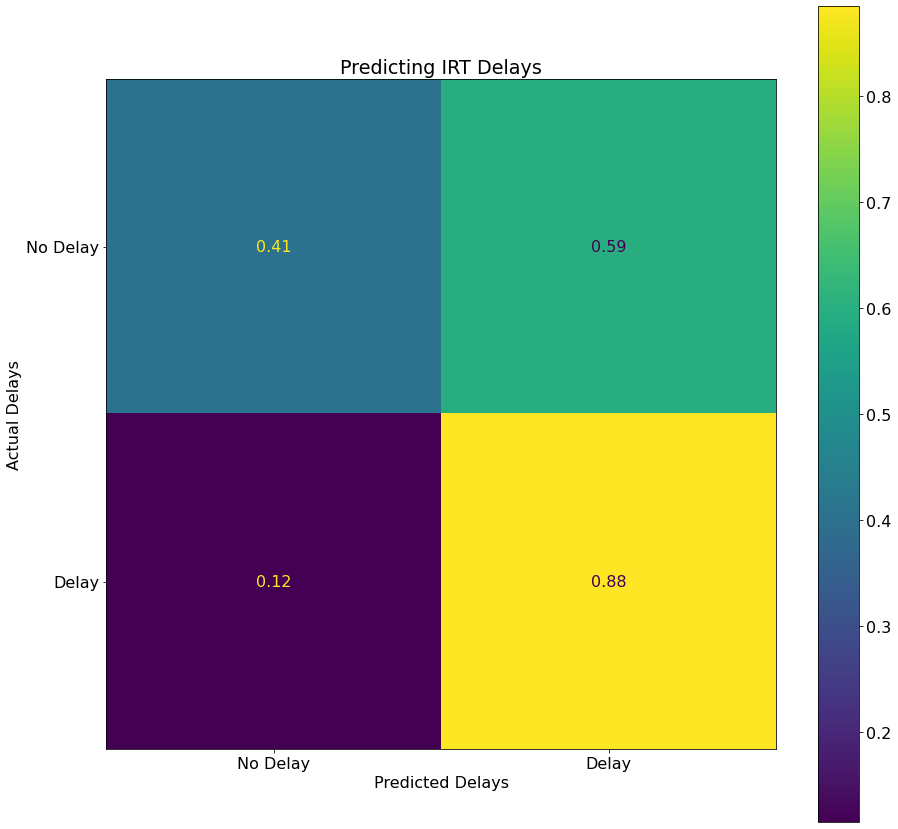


Overall Accuracy: 69.14%,
F1 Score: 77.36%


In [76]:
y_pred = gsv_lr.best_estimator_.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(gsv_lr, X_test, y_test, normalize='true', ax=ax, display_labels=['No Delay','Delay'])
ax.set_xlabel('Predicted Delays')
ax.set_ylabel('Actual Delays')
ax.set_title('Predicting IRT Delays')
plt.show()

print(f"""
Overall Accuracy: {(round(accuracy_score(y_test, y_pred), 4)*100)}%,
F1 Score: {(round(f1_score(y_test,y_pred),4)*100)}%""")

In [77]:
y_pred = xg_cl.predict(X_test)

# fig, ax = plt.subplots(figsize=(15, 15))
# plt.rcParams.update({'font.size': 16})
# plot_confusion_matrix(xg_cl, X_test, y_test, normalize='true', ax=ax, display_labels=['No Delay','Delay'])
# ax.set_xlabel('Predicted Delays')
# ax.set_ylabel('Actual Delays')
# ax.set_title('Predicting IRT Delays')
# plt.show()

print(f"""
Overall Accuracy: {(round(accuracy_score(y_test, y_pred), 4)*100)}%""")


Overall Accuracy: 69.23%


So, it appears that LogReg actually works the best on Division B trains alone.

BNB works best on Division A trains and overall.

# Saving the best models

In [79]:
bnb_model = 'bnbmodel.sav'
pkl.dump(model_bnb, open(bnb_model,'wb'))

xgb_model = 'xgbmodel.sav'
pkl.dump(model_xgb, open(xgb_model,'wb'))

logreg_model = 'logregmodel.sav'
pkl.dump(model_lr, open(logreg_model,'wb'))